In [1]:
# Importing Libraries

import os
import numpy as np
import pandas as pd

from PIL import Image
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display

In [2]:
import os
import pandas as pd

# Setting data directory
data_directory = os.path.join("dataverse_files")
os.listdir(data_directory)

# Loading HAM10000_metadata.csv
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata'))

In [3]:
# Creating dictionary for image path, and lesion type
# Adding images from both the folders
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

#%%time
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path,image_pixel
9269,HAM_0006967,ISIC_0026295,nv,consensus,60.0,female,back,vidir_modern,Melanocytic nevi (nv),dataverse_files/HAM10000_images_part_1/ISIC_00...,"[[[166, 108, 105], [171, 113, 110], [176, 124,..."
3327,HAM_0002215,ISIC_0028539,nv,follow_up,45.0,female,back,vidir_molemax,Melanocytic nevi (nv),dataverse_files/HAM10000_images_part_1/ISIC_00...,"[[[222, 152, 145], [224, 154, 149], [225, 153,..."
8438,HAM_0005855,ISIC_0031727,nv,histo,60.0,male,lower extremity,rosendahl,Melanocytic nevi (nv),dataverse_files/HAM10000_images_part_2/ISIC_00...,"[[[150, 112, 125], [150, 115, 127], [165, 129,..."
3043,HAM_0003548,ISIC_0028480,nv,follow_up,55.0,male,back,vidir_molemax,Melanocytic nevi (nv),dataverse_files/HAM10000_images_part_1/ISIC_00...,"[[[226, 144, 143], [233, 148, 147], [237, 147,..."
5538,HAM_0004294,ISIC_0028153,nv,follow_up,50.0,female,foot,vidir_molemax,Melanocytic nevi (nv),dataverse_files/HAM10000_images_part_1/ISIC_00...,"[[[203, 130, 149], [202, 124, 148], [209, 132,..."


In [4]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=data['sex'].value_counts().index, 
            y=data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=data['localization'].value_counts().index, 
            y=data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=data['dx'].value_counts().index.map(lesion_type_dict.get), 
            y=data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)

fig.show()

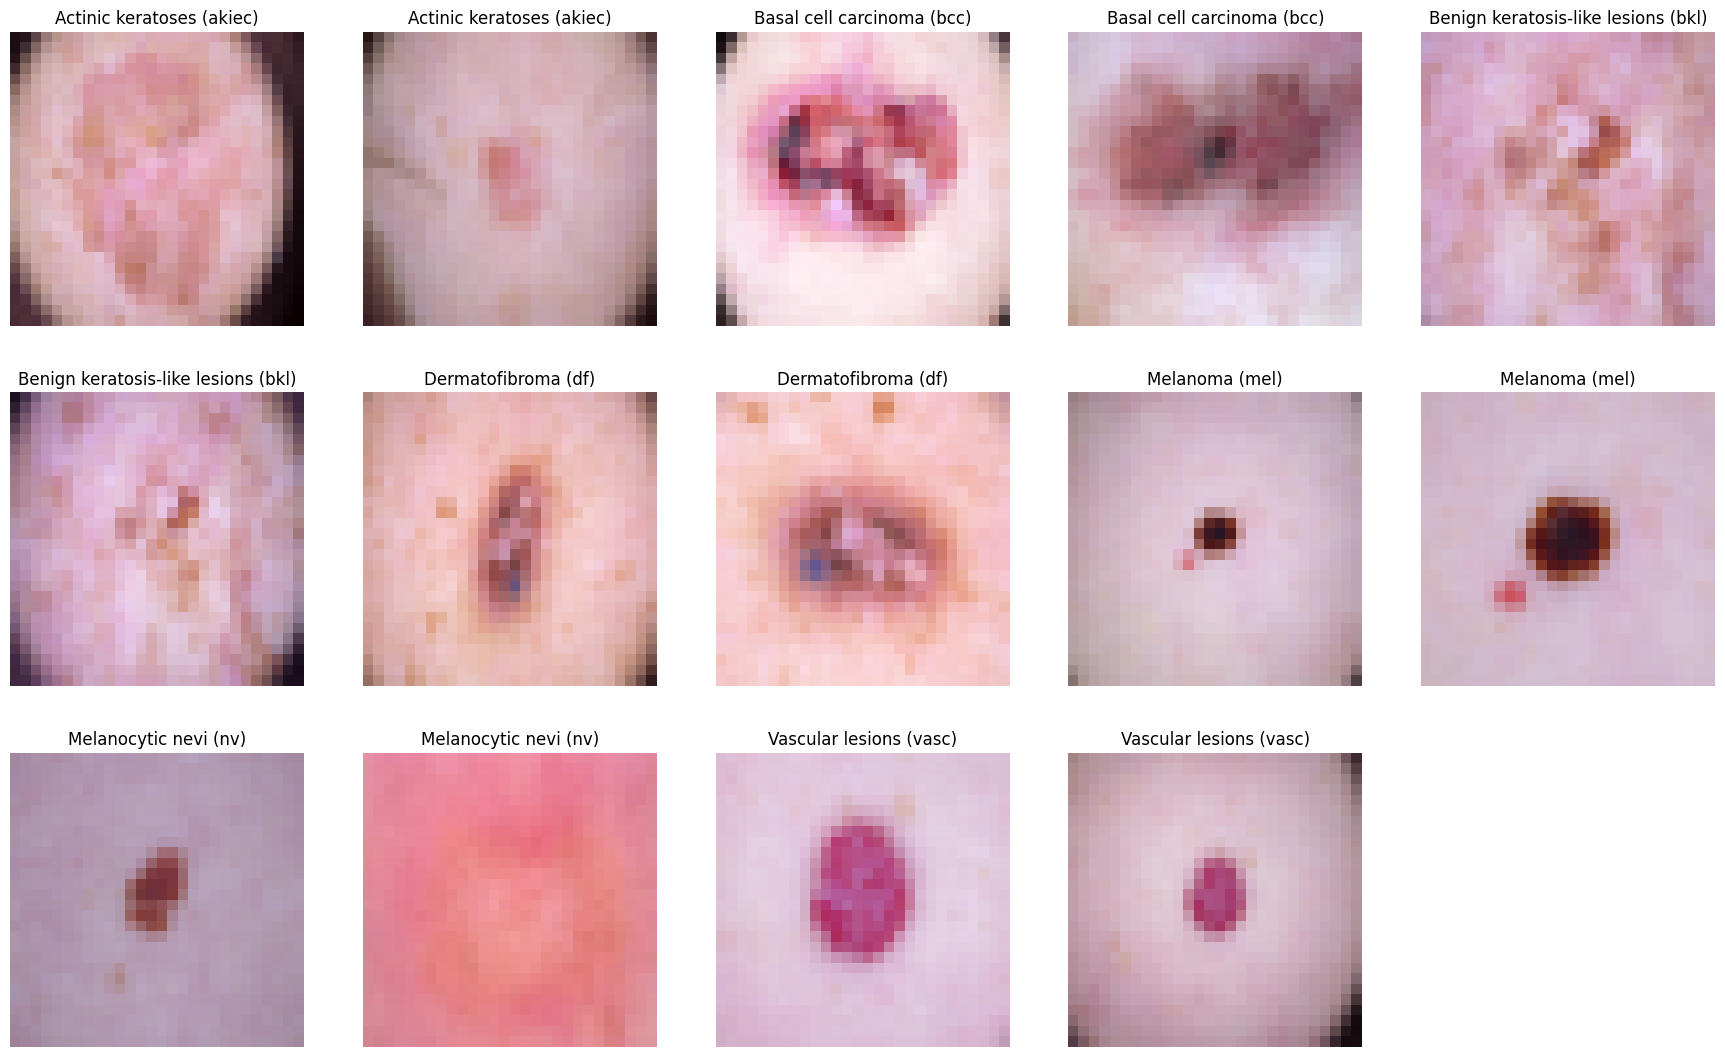

In [5]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7, 8, 10]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'].iloc[i]))
    img_label = sample_data['cell_type'].iloc[i]
    plt.title(img_label)
    plt.axis("off")
plt.show()


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
 8   cell_type     10015 non-null  object 
 9   path          10015 non-null  object 
 10  image_pixel   10015 non-null  object 
dtypes: float64(1), object(10)
memory usage: 860.8+ KB


In [7]:
# Checking null values
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
cell_type        0
path             0
image_pixel      0
dtype: int64

In [8]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')
# Categorically encoding label of the images 
data['label'] = data['dx'].map(reverse_label_mapping.get)
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path,image_pixel,label
258,HAM_0007402,ISIC_0033079,bkl,histo,60,female,lower extremity,vidir_modern,Benign keratosis-like lesions (bkl),dataverse_files/HAM10000_images_part_2/ISIC_00...,"[[[211, 194, 203], [215, 197, 207], [219, 201,...",2
4627,HAM_0006446,ISIC_0025591,nv,follow_up,60,male,trunk,vidir_molemax,Melanocytic nevi (nv),dataverse_files/HAM10000_images_part_1/ISIC_00...,"[[[229, 143, 146], [232, 149, 161], [233, 153,...",0
39,HAM_0003847,ISIC_0028560,bkl,histo,85,male,upper extremity,vidir_modern,Benign keratosis-like lesions (bkl),dataverse_files/HAM10000_images_part_1/ISIC_00...,"[[[62, 46, 57], [114, 86, 95], [142, 112, 123]...",2
1965,HAM_0001444,ISIC_0024688,mel,histo,40,female,lower extremity,vienna_dias,Melanoma (mel),dataverse_files/HAM10000_images_part_1/ISIC_00...,"[[[203, 162, 185], [204, 164, 193], [205, 164,...",1
7326,HAM_0001692,ISIC_0032743,nv,histo,40,female,chest,vidir_modern,Melanocytic nevi (nv),dataverse_files/HAM10000_images_part_2/ISIC_00...,"[[[214, 220, 246], [210, 212, 243], [206, 208,...",0


In [9]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming 'data' DataFrame is already loaded and processed

data = data.sort_values('label')
data = data.reset_index(drop=True)

index1 = data[data['label'] == 1].index.values
index2 = data[data['label'] == 2].index.values
index3 = data[data['label'] == 3].index.values
index4 = data[data['label'] == 4].index.values
index5 = data[data['label'] == 5].index.values
index6 = data[data['label'] == 6].index.values

df_index1 = data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = data.iloc[int(min(index3)):int(max(index3)+1)]
df_index4 = data.iloc[int(min(index4)):int(max(index4)+1)]
df_index5 = data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = data.iloc[int(min(index6)):int(max(index6)+1)]

df_index1 = pd.concat([df_index1] * 5, ignore_index=True)
df_index2 = pd.concat([df_index2] * 5, ignore_index=True)
df_index3 = pd.concat([df_index3] * 12, ignore_index=True)
df_index4 = pd.concat([df_index4] * 18, ignore_index=True)
df_index5 = pd.concat([df_index5] * 46, ignore_index=True)
df_index6 = pd.concat([df_index6] * 53, ignore_index=True)

frames = [data, df_index1, df_index2, df_index3, df_index4, df_index5, df_index6]
final_data = pd.concat(frames)

print(data.shape)
print(final_data.shape)

fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=final_data['sex'].value_counts().index, 
            y=final_data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=final_data['localization'].value_counts().index, 
            y=final_data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=final_data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=final_data['dx'].value_counts().index.map(lesion_type_dict.get), 
            y=final_data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data after augmentation', height=800)

fig.show()

(10015, 12)
(45756, 12)


In [10]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)
(10015, 28, 28, 3)
(10015, 1)

# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(10015, 28, 28, 3)
(10015, 1)
(45756, 28, 28, 3)
(45756, 1)


In [11]:
#%%time
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), 
    activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
#     tf.keras.utils.plot_model(model, to_file="model.png")
    return model;

def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto', restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history
    
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()
    
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)
model1 = create_model()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

2025-01-29 10:59:31.401693: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-01-29 10:59:31.401756: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-29 10:59:31.401776: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-29 10:59:31.401799: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-29 10:59:31.401818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhos

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,583 (517.90 KB)

 Trainable params: 132,583 (517.90 KB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
model1_history = train_model(model1, X_train_orig, Y_train_orig, 50)

Epoch 1/50


2025-01-29 10:59:38.248840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5342 - loss: 5.0333 - val_accuracy: 0.6294 - val_loss: 1.0257 - learning_rate: 0.0010
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6717 - loss: 0.9441 - val_accuracy: 0.6756 - val_loss: 0.9001 - learning_rate: 0.0010
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7079 - loss: 0.8503 - val_accuracy: 0.6762 - val_loss: 0.8631 - learning_rate: 0.0010
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6999 - loss: 0.8567 - val_accuracy: 0.6993 - val_loss: 0.8499 - learning_rate: 0.0010
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7253 - loss: 0.7866 - val_accuracy: 0.7087 - val_loss: 0.8177 - learning_rate: 0.0010
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7314 - loss: 0.7610 - val_accuracy: 0.7068 - val_loss: 0.8136 - learning_rate: 0.0010
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7138 - loss: 0.7949 - val_

In [13]:
# For Augmented Dataset
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)
model2 = create_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,583 (517.90 KB)

 Trainable params: 132,583 (517.90 KB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
model2_history = train_model(model2, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.3436 - loss: 2.6784 - val_accuracy: 0.6507 - val_loss: 0.9686 - learning_rate: 0.0010
Epoch 2/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6933 - loss: 0.8227 - val_accuracy: 0.7039 - val_loss: 0.7659 - learning_rate: 0.0010
Epoch 3/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7982 - loss: 0.5505 - val_accuracy: 0.8291 - val_loss: 0.4461 - learning_rate: 0.0010
Epoch 4/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8590 - loss: 0.3826 - val_accuracy: 0.8629 - val_loss: 0.3911 - learning_rate: 0.0010
Epoch 5/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8877 - loss: 0.3041 - val_accuracy: 0.8745 - val_loss: 0.3465 - learning_rate: 0.0010
Epoch 6/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9051 - loss: 0.2511 - val_accuracy: 0.8724 - val_loss: 0.3477 - learning_rate: 0.0010
Epoch 7/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9243 - loss: 0

Test Accuracy: 77.034%
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

          nv       0.87      0.92      0.90      1374
         mel       0.51      0.43      0.47       205
         bkl       0.54      0.41      0.46       227
         bcc       0.44      0.63      0.52        94
       akiec       0.42      0.31      0.36        55
        vasc       0.76      0.57      0.65        28
          df       0.00      0.00      0.00        20

    accuracy                           0.77      2003
   macro avg       0.51      0.47      0.48      2003
weighted avg       0.75      0.77      0.76      2003



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



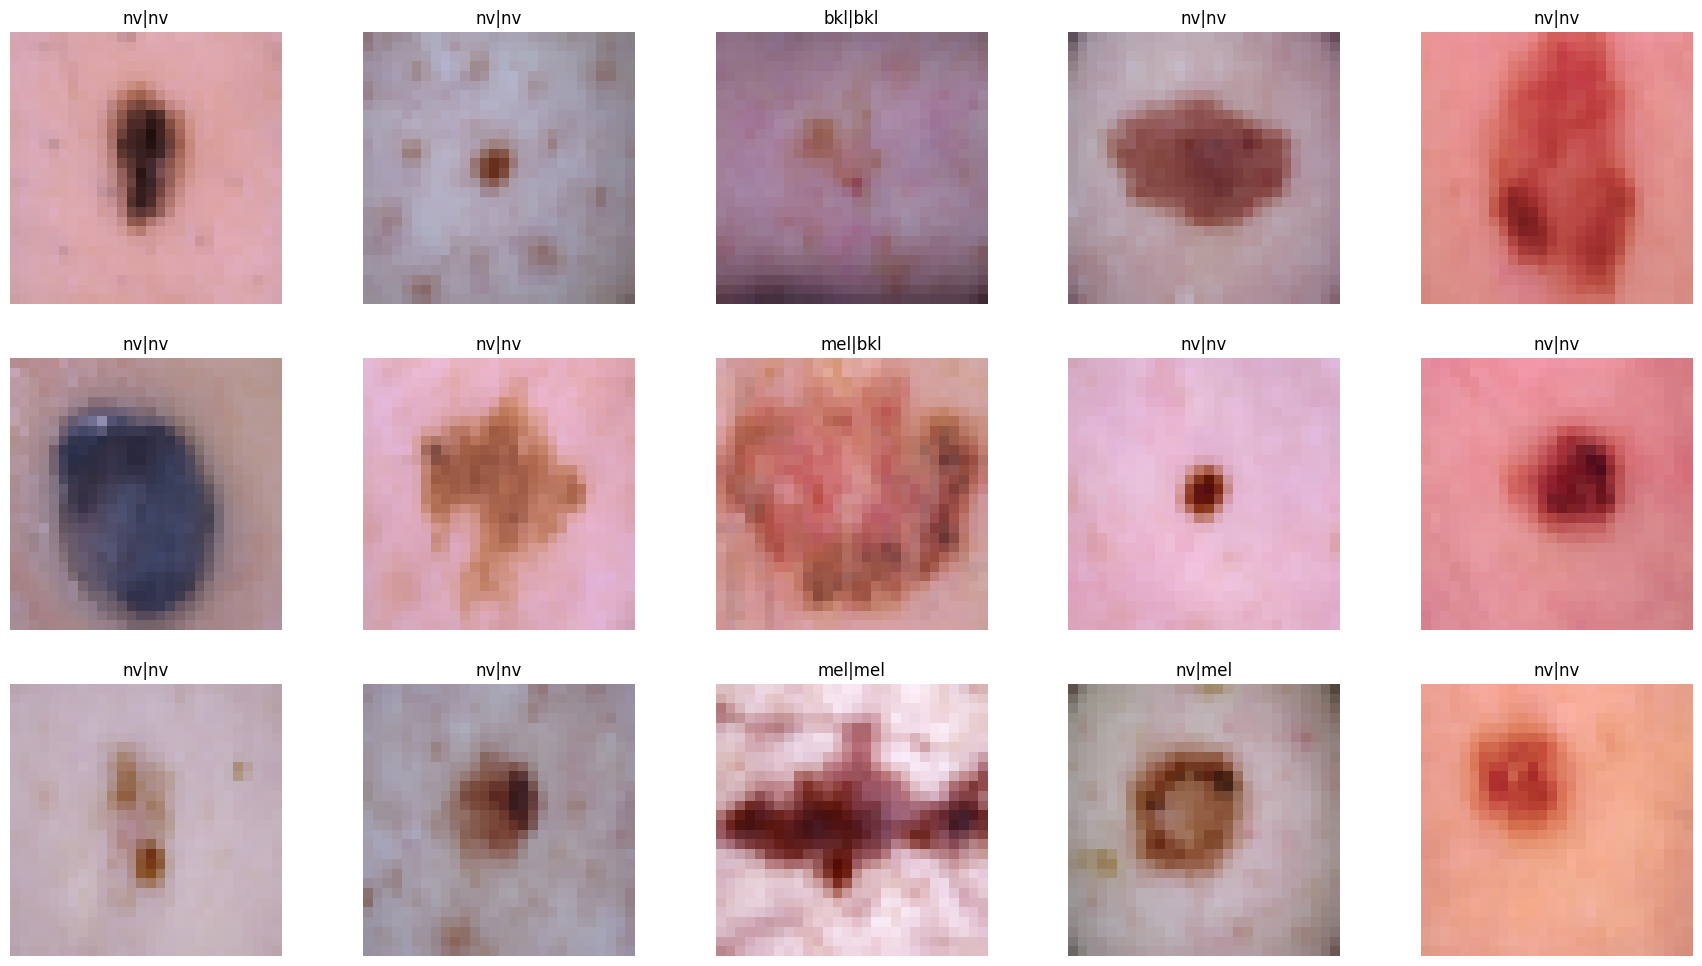

In [16]:
test_model(model1, X_test_orig, Y_test_orig)


Test Accuracy: 98.088%
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

          nv       0.99      0.88      0.93      1385
         mel       0.95      0.99      0.97      1328
         bkl       0.96      1.00      0.98      1294
         bcc       0.99      1.00      0.99      1325
       akiec       0.99      1.00      1.00      1270
        vasc       1.00      1.00      1.00      1293
          df       1.00      1.00      1.00      1257

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.98      9152



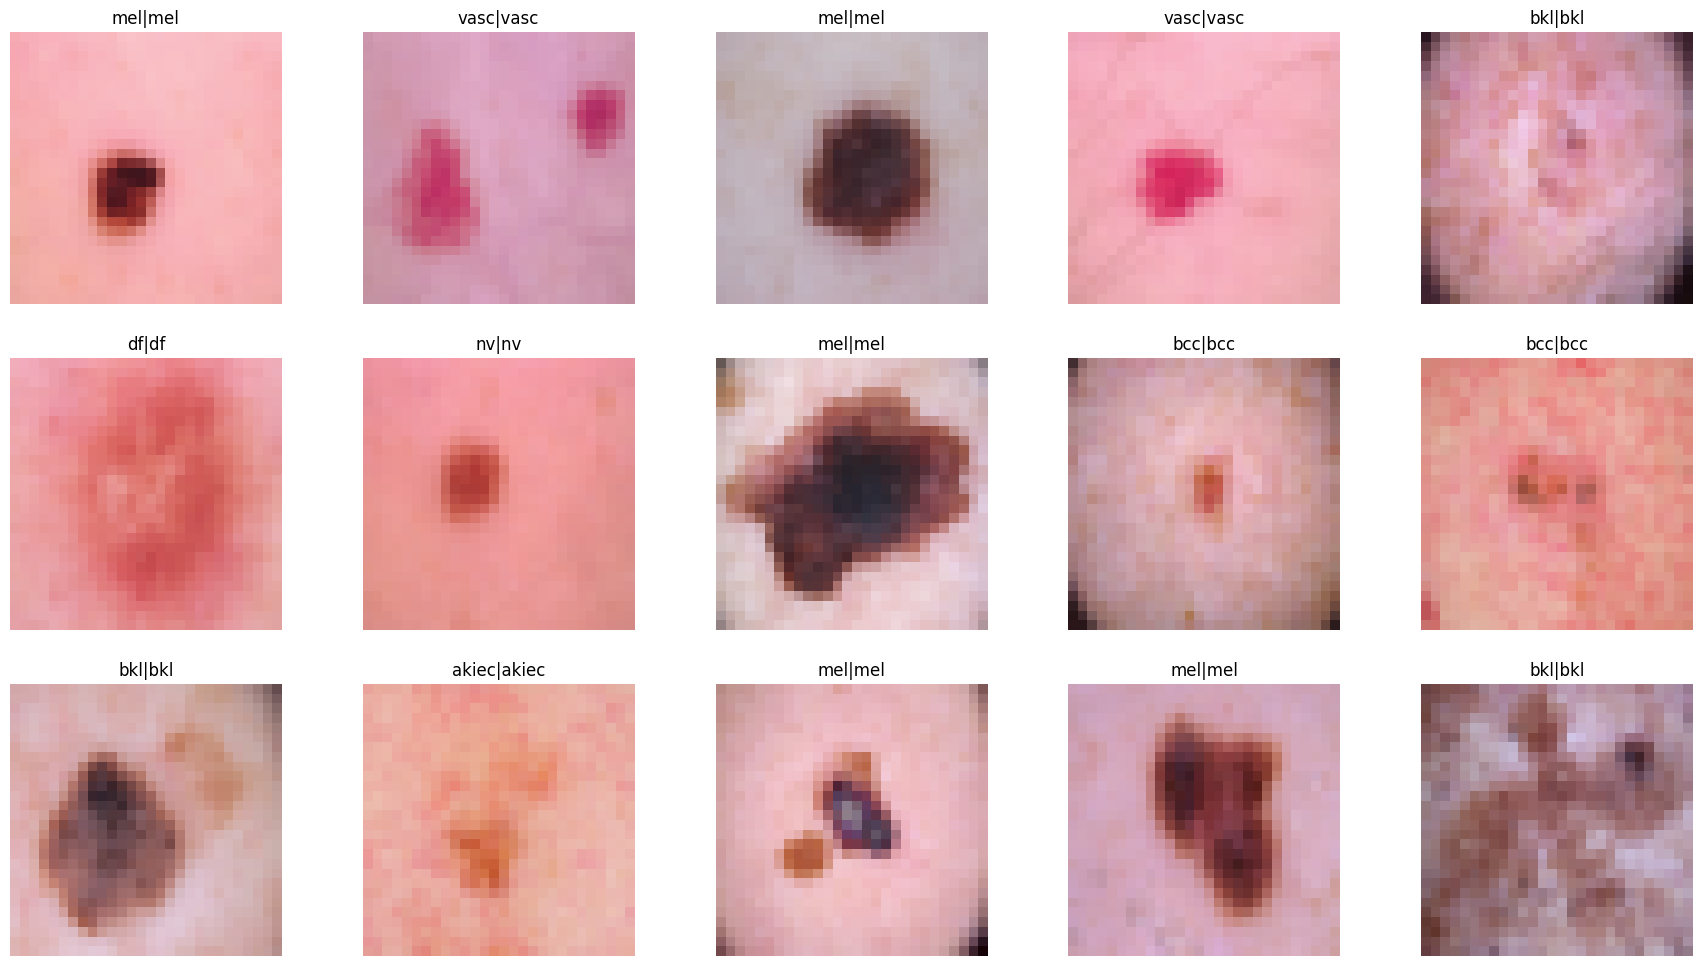

In [18]:
test_model(model2, X_test_aug, Y_test_aug)

In [19]:
plot_model_training_curve(model1_history)

In [20]:
plot_model_training_curve(model2_history)

In [37]:
# Save the trained models
model1.save("model1.h5")  # Saves the original dataset model
model2.save("model2.h5")  # Saves the augmented dataset model


2025-02-03 15:17:26.934692: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-02-03 15:17:26.934774: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-02-03 15:17:26.934799: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-02-03 15:17:26.934832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-03 15:17:26.934864: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-02-03 15:17:28.644841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


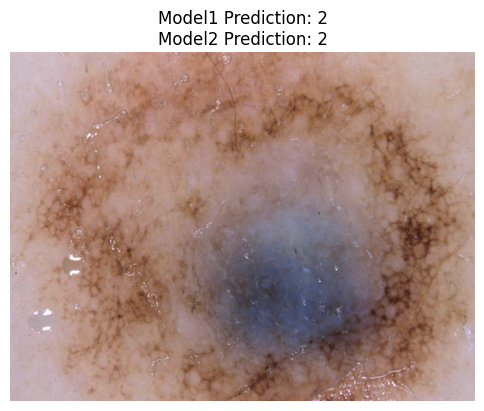

(2, 2)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load trained models
model1 = load_model("model1.h5")  # Change path if needed
model2 = load_model("model2.h5")  # Change path if needed

def preprocess_image(img_path, target_size=(28, 28)):  
    """Preprocesses the image for model prediction."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize
    return img_array

def predict_image(img_path):
    """Predicts the class of the uploaded image using both models."""
    img_array = preprocess_image(img_path)

    # Make predictions
    pred1 = model1.predict(img_array)
    pred2 = model2.predict(img_array)

    # Convert probabilities to class labels
    label1 = np.argmax(pred1)
    label2 = np.argmax(pred2)

    # Display the image and results
    plt.figure(figsize=(6, 6))
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Model1 Prediction: {label1}\nModel2 Prediction: {label2}")
    plt.show()

    return label1, label2

# Example usage:
image_path = "/Users/samrudhsalas/Downloads/SkinGuard/dataverse_files/ISIC2018_Task3_Test_Images/ISIC_0034680.jpg"  # Replace with actual path
predict_image(image_path)
